In [3]:
using DataFrames, Dates
using StatsBase: maximum, minimum, median, mean, countmap
import PlotlyJS
include("../Sensors/sensors.jl")
include("../PreProcessing/preprocessing.jl")
include("../helpers.jl")
include("../visualizations.jl");

## Load the data and format it

In [4]:
datafolder = "../../Data/Twitter/"
datafile = datafolder * "all_links_processed.json"
data = load_json(datafile)

#datafiles = [file for file in readdir(datafolder) if occursin("processed.json", file)]
#frames = [load_json(datafolder * file) for file in datafiles]
#data = vcat(frames...)

#=
data = CSV.read(datafiles[1], DataFrame, header=1, types=String)

#new_row = DataFrame(id = "0006", author_id = "6", username = "?Cyril06", created_at = "2021-10-31T00:09:04.000Z", lang = "en", text = "test climate change", original_text = "test climate change",
#    hashtags = missing, category = "['tweeted']", URLs = "['https://www.cnn.com/test']", domain = "['cnn']", domain_suffix = "['com']", country = missing, country_code = missing, sentiment = "neutral")
#append!(data, new_row);

function str_to_vec(string)
    if ismissing(string)
        return missing
    end
    # remove `[]` characters at beginning and end, and split based on commas following a quote char
    list = split(string[2:end-1], "', ")
    res = []
    for str in list
        if first(str) == '\'' && last(str) == '\''
            push!(res, String(collect(str)[2:end-1]))
        elseif first(str) == '\''
            push!(res, String(collect(str)[2:end]))
        elseif last(str) == '\''
            push!(res, String(collect(str)[1:end-1]))
        end
    end
    return res
end

data."hashtags" = data."hashtags" .|> str_to_vec
data."category" = data."category" .|> str_to_vec
data."URLs" = data."URLs" .|> str_to_vec
data."domain" = data."domain" .|> str_to_vec
data."domain_suffix" = data."domain_suffix" .|> str_to_vec

=#

data = data[.~ismissing.(data."urls"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

## Define the partition, actors and actions

In [6]:
part_fun = sentiment
actor_fun = follower_count
action_fun = trust_popularity_score

cuttoff = 0.5
et = "Any Edge"
part = "neutral"

clean_dates = x -> floor(x, Dates.Hour(2));
data.time = clean_dates.(data."created_at");

df = data |> part_fun |> action_fun |> actor_fun;

## Compute influence graph

In [7]:

tsg = TimeSeriesGenerator()
time_series = observe(df, tsg)

ig = InfluenceGrapher()
influence_graph = observe(time_series, ig);

## Compte influence cascade and plot influence graph

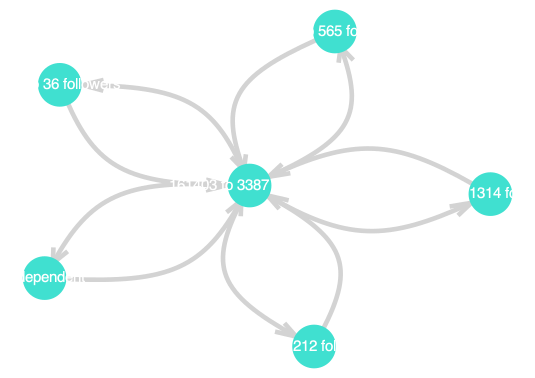

In [8]:
begin
	function make_simplifier(edge_type)
		if edge_type=="Any Edge"
			return x->(maximum(x)>cuttoff)
		else
			idx = findfirst(x->(x==et), edgeTypes)
			return x->(x[idx]>cuttoff)
		end
	end
	s = make_simplifier(et)

	icg = InfluenceCascadeGenerator(cuttoff)
	influence_cascades = observe.(influence_graph, Ref(icg))
	all_ics = vcat(influence_cascades...)

	
	partitions = unique(df[!,tsg.part_col])
	i = (1:length(partitions))[findfirst(x->x==part, partitions)]
	#xs, ys, influencers = influence_layout(influence_graph[i]; simplifier=s)

	# In this case we plot the graph on a world map
	if actor_fun == country
		PlotlyJS.plot(map_plot(df)...)
	# In this case we plot a simple graph of the actors
	else
		#gplot(g, xs, ys, nodelabel=unique(df.actor))
		g, labels = plot_graph(influence_graph[i], df, simplifier=s)
		gplot(g, nodelabel=labels, nodelabelc=colorant"white", linetype="curve")
	end
	
end

In [ ]:
infl = unique(df.actor)[influencers]
influencer_node1 = infl[1]
influencer_node2 = infl[1]

PlotlyJS.plot(plot_cascade_sankey(
	influence_cascades[findfirst(x->x==part,unique(df[!, tsg.part_col]))][findfirst(x->x==influencer_node1, unique(df[!, tsg.actor_col])[influencers])],
	unique(df[!, tsg.action_col]))...)

In [ ]:
PlotlyJS.savefig(PlotlyJS.plot(plot_cascade_sankey(
	influence_cascades[2][4], unique(df[!, tsg.action_col]))...), "sankey.png")

In [ ]:
show(plot_actors_per_level(influence_cascades, df, save=true, filename="ic.pdf"))

In [ ]:
plot_actor_wordcloud(df, Nactor=300, save=true, filename="wordcloud.svg")

In [ ]:
show(plot_actor_frequency(df, save=true, filename="boxplot.pdf"))

In [ ]:
include("../visualizations.jl");
show(plot_action_frequency(df, split_by_partition = true, save=true, filename="actions.pdf"))

In [ ]:
include("../visualizations.jl");
show(plot_action_frequency_v2(df, split_by_partition = true))

In [ ]:
include("../PreProcessing/preprocessing.jl")

In [ ]:
username(df)

In [ ]:
@__FILE__

In [6]:
a = ["test", "test2", "foo"]
[i[1:2] for i in a]

3-element Vector{String}:
 "te"
 "te"
 "fo"